In [97]:
import os
import sys
import pickle

PROJECT_ROOT = os.path.abspath('..')
sys.path.append(PROJECT_ROOT)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

from sleeprnn.helpers.reader import load_dataset
from sleeprnn.common import constants, viz, pkeys
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection.predicted_dataset import PredictedDataset
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import det_utils
from figs_thesis import fig_utils

viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

RESULTS_PATH = os.path.join(PROJECT_ROOT, 'results')

# Max amplitude preliminaries

In [ ]:
mass = load_dataset('mass_kc')
signals = mass.get_signals(normalize_clip=False)
marks = mass.get_stamps(pages_subset='n2')

In [ ]:
all_kc_min = []
all_kc_max = []
for sub_signal, sub_marks in zip(signals, marks):
    kc = [sub_signal[m[0]:m[1]+1] for m in sub_marks]
    kc_min = np.array([np.min(s) for s in kc])
    kc_max = np.array([np.max(s) for s in kc])
    all_kc_min.append(kc_min)
    all_kc_max.append(kc_max)
all_kc_min = np.concatenate(all_kc_min)
all_kc_max = np.concatenate(all_kc_max)
print(all_kc_min.shape, all_kc_max.shape)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=100)
ax = axes[0]
ax.hist(all_kc_min)
ax.set_title("Neg Peak")
ax = axes[1]
ax.hist(all_kc_max)
ax.set_title("Pos Peak")
plt.tight_layout()
plt.show()

prct = 98

print("Negative Peak prct %d: %1.4f uV" % (prct, np.percentile(all_kc_min, 100-prct)))
print("Positive Peak prct %d: %1.4f uV" % (prct, np.percentile(all_kc_max, prct)))

# NSRR EXPLORATION

In [3]:
class PredictedNSRR(object):
    def __init__(
        self,
        experiment_folder='20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
        grid_folder='v2_time',
        page_duration=30,
        min_separation=0.3,
        min_duration=0.3,
        max_duration=3.0,
        repair_long_detections=False,
    ):
        self.experiment_folder = experiment_folder
        self.grid_folder = grid_folder
        self.subject_to_fold_map = self._hash_predictions()
        self.all_ids = np.sort(list(self.subject_to_fold_map.keys()))        
        self.post_params = {
            pkeys.PAGE_DURATION: page_duration,
            pkeys.SS_MIN_SEPARATION: min_separation,
            pkeys.SS_MIN_DURATION: min_duration,
            pkeys.SS_MAX_DURATION: max_duration,
            pkeys.REPAIR_LONG_DETECTIONS: repair_long_detections,
        }

    def get_predictions(self, fold_ids_list, dataset, threshold=0.5):
        proba_dict = {}
        for fold_id in fold_ids_list:
            t_proba_dict = self.get_fold_probabilities(fold_id)
            proba_dict.update(t_proba_dict)
        subject_ids = list(proba_dict.keys())
        subject_ids.sort()
        feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=1)
        feed_d.unknown_id = dataset.unknown_id
        feed_d.n2_id = dataset.n2_id
        feed_d.original_page_duration = dataset.original_page_duration
        prediction = PredictedDataset(
            dataset=feed_d,
            probabilities_dict=proba_dict,
            params=self.post_params.copy(), skip_setting_threshold=True)
        prediction.set_probability_threshold(threshold)
        return prediction
        
    def get_subject_fold(self, subject_id):
        return self.subject_to_fold_map[subject_id]
    
    def get_fold_probabilities(self, fold_id):
        pred_path = os.path.join(RESULTS_PATH, 'predictions_nsrr_ss', self.experiment_folder, self.grid_folder)
        fold_path = os.path.join(pred_path, 'fold%d' % fold_id, 'prediction_n2_test.pkl')
        with open(fold_path, 'rb') as handle:
            proba_dict = pickle.load(handle)
        return proba_dict
    
    def _hash_predictions(self):
        pred_path = os.path.join(RESULTS_PATH, 'predictions_nsrr_ss', self.experiment_folder, self.grid_folder)
        folds = os.listdir(pred_path)
        folds = [int(f.split("fold")[-1]) for f in folds]
        folds = np.sort(folds)
        
        subject_to_fold_map = {}
        for fold_id in folds:
            proba_dict = self.get_fold_probabilities(fold_id)
            fold_subjects = list(proba_dict.keys())
            for subject_id in fold_subjects:
                subject_to_fold_map[subject_id] = fold_id
        return subject_to_fold_map

In [4]:
nsrr_preds = PredictedNSRR()

In [5]:
nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True)

Dataset nsrr_ss with 3 patients.
Loading from checkpoint... Loaded
Global STD: None
Dataset nsrr_ss with 11593 patients.


# Reproducción de tendencias

In [7]:
n_folds = 10

fold_ids_list = np.arange(n_folds)
predictions = nsrr_preds.get_predictions(fold_ids_list, nsrr)

print("Loaded predictions for %d subjects" % (len(predictions.all_ids)))

Loaded predictions for 1000 subjects


In [130]:
min_n2_minutes = 60

subject_ids = predictions.all_ids

table_byevent = {'duration': []}
table_bysubject = {
    'subject_id': [], 
    'duration': [], 'density': [], 'proba_event': [], 
    'n2_minutes': [], 'origin': [],
    'age': [], 'female': [],
}
for i in range(len(subject_ids)):
    subject_id = subject_ids[i]
    n2_pages = predictions.data[subject_id]['n2_pages']
    n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
    
    if n2_minutes < min_n2_minutes:
        print("Skipped by N2 minutes: Subject %s with %d N2 minutes" % (subject_id, n2_minutes))
        continue
        
    subject_data = nsrr.read_subject_data(subject_id)
    
    # ################
    # Exclusion criteria
    
    # Power law exponent
    min_pl_exponent = -1.8865295794219255 
    max_pl_exponent = -0.7870561981462284
    signal = subject_data['signal']
    x_pages = signal.reshape(-1, nsrr.original_page_duration * nsrr.fs)[n2_pages]
    new_n2_pages = []
    for single_n2_page, x in zip(n2_pages, x_pages):
        freq, power = utils.power_spectrum_by_sliding_window(x, nsrr.fs, window_duration=2)
        locs_to_use = np.where((freq >= 4) & (freq <= 30))[0]
        x_data = freq[locs_to_use]
        y_data = power[locs_to_use]
        locs_no_sigma = np.where((x_data < 10) | (x_data > 17))[0]
        x_data_no_sigma = x_data[locs_no_sigma]
        y_data_no_sigma = y_data[locs_no_sigma]
        # Therefore we are considering frequencies 4-10 and 17-30 Hz for the power law.
        log_x = np.log(x_data_no_sigma)
        log_y = np.log(y_data_no_sigma)
        pl_exponent, _, _, _, _ = scipy.stats.linregress(log_x,log_y)
        if pl_exponent >= min_pl_exponent and pl_exponent <= max_pl_exponent:
            new_n2_pages.append(single_n2_page)
    n2_pages = np.array(new_n2_pages)
    # ##############
    
    n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
    
    if n2_minutes < min_n2_minutes:
        print("Skipped by N2 minutes [post power law]: Subject %s with %d N2 minutes" % (subject_id, n2_minutes))
        continue
    
    marks = predictions.get_subject_stamps(subject_id)
    n_marks = marks.shape[0]
    
    if n_marks == 0:
        print("Skipped by Marks     : Subject %s with %d marks (%d N2 minutes)" % (subject_id, n_marks, n2_minutes))
        continue

    durations = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs
    subject_proba = predictions.get_subject_stamps_probabilities(subject_id)
    
    subject_mean_duration = np.mean(durations)
    subject_density = n_marks / n2_minutes
    subject_mean_proba = np.mean(subject_proba)
    subdataset = subject_id[:-4]
    
    age = float(subject_data['age'].item())
    female = int(subject_data['sex'].item() == 'f')
    
    table_byevent['duration'].append(durations)
    table_bysubject['subject_id'].append(subject_id)
    table_bysubject['duration'].append(subject_mean_duration)
    table_bysubject['density'].append(subject_density)
    table_bysubject['proba_event'].append(subject_mean_proba)
    table_bysubject['n2_minutes'].append(n2_minutes)
    table_bysubject['origin'].append(subdataset)
    table_bysubject['age'].append(age)
    table_bysubject['female'].append(female)
    
for key in table_byevent:
    table_byevent[key] = np.concatenate(table_byevent[key])
table_byevent = pd.DataFrame.from_dict(table_byevent)
table_bysubject = pd.DataFrame.from_dict(table_bysubject)
print("Done.")

Skipped by N2 minutes: Subject cfs-visit5-800393 with 27 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-300365 with 2 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-301091 with 36 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-301108 with 57 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-nonrandomized-300521 with 0 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-nonrandomized-300607 with 0 N2 minutes
Skipped by N2 minutes [post power law]: Subject mros-visit1-aa0121 with 3 N2 minutes
Skipped by N2 minutes: Subject mros-visit1-aa0965 with 18 N2 minutes
Skipped by N2 minutes: Subject mros-visit1-aa5622 with 13 N2 minutes
Skipped by N2 minutes [post power law]: Subject shhs1-200004 with 50 N2 minutes
Skipped by N2 minutes: Subject shhs1-200489 with 24 N2 minutes
Skipped by N2 minutes [post power law]: Subject shhs1-201581 with 18 N2 minutes
Skipped by N2 minutes [post power law]: Subject shhs1-201711 with 1 N2 minutes
Skipped by N2 minutes: Subj

In [131]:
table_byevent

,duration
0,0.44
1,0.72
2,1.48
3,0.60
4,0.64
...,...
212876,0.40
212877,0.68
212878,0.36
212879,0.84


In [132]:
table_bysubject

,subject_id,duration,density,proba_event,n2_minutes,origin,age,female
0,ccshs-trec-1800034,1.121019,5.055215,0.925283,163.0,ccshs-trec-180,17.40,1
1,ccshs-trec-1800038,1.105720,4.729927,0.885380,205.5,ccshs-trec-180,17.40,1
2,ccshs-trec-1800065,0.955523,3.072398,0.883508,221.0,ccshs-trec-180,17.68,1
3,ccshs-trec-1800074,0.874167,2.915888,0.874492,214.0,ccshs-trec-180,17.86,1
4,ccshs-trec-1800078,0.834557,2.695096,0.855022,234.5,ccshs-trec-180,17.77,0
...,...,...,...,...,...,...,...,...
973,sof-visit-8-09018,0.732103,1.351621,0.872237,200.5,sof-visit-8-0,81.00,1
974,sof-visit-8-09036,0.728224,0.926407,0.849786,231.0,sof-visit-8-0,81.00,1
975,sof-visit-8-09614,0.971579,0.849162,0.703575,89.5,sof-visit-8-0,83.00,1
976,sof-visit-8-09627,0.698621,1.064220,0.787899,109.0,sof-visit-8-0,82.00,1


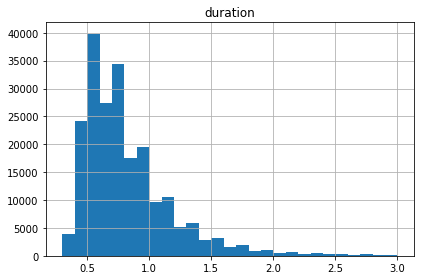

In [133]:
# by-event stuff
table_byevent.hist(bins=np.arange(0.3, 3.0 + 0.001, 0.1))
plt.tight_layout()
plt.show()

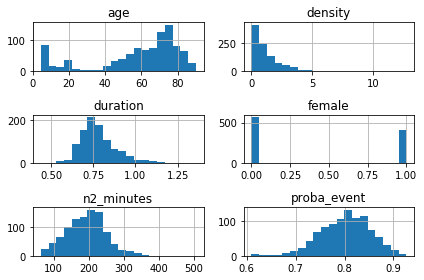

In [134]:
table_bysubject.hist(bins=20)
plt.tight_layout()
plt.show()

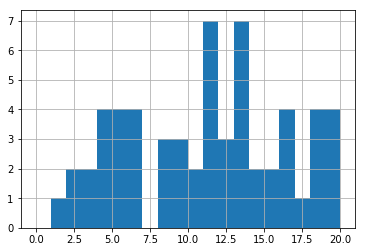

1.0


In [135]:
a = (table_bysubject['n2_minutes'] * table_bysubject['density'])
a[a <= 20].hist(bins=np.arange(0, 20 + 0.001, 1))
plt.show()
print(a.min())

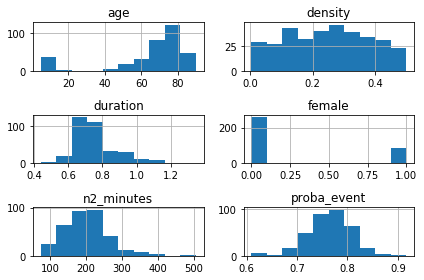

In [136]:
zoom_density = 0.5

table_zoom = table_bysubject[table_bysubject.density < zoom_density]
table_zoom.hist()
plt.tight_layout()
plt.show()

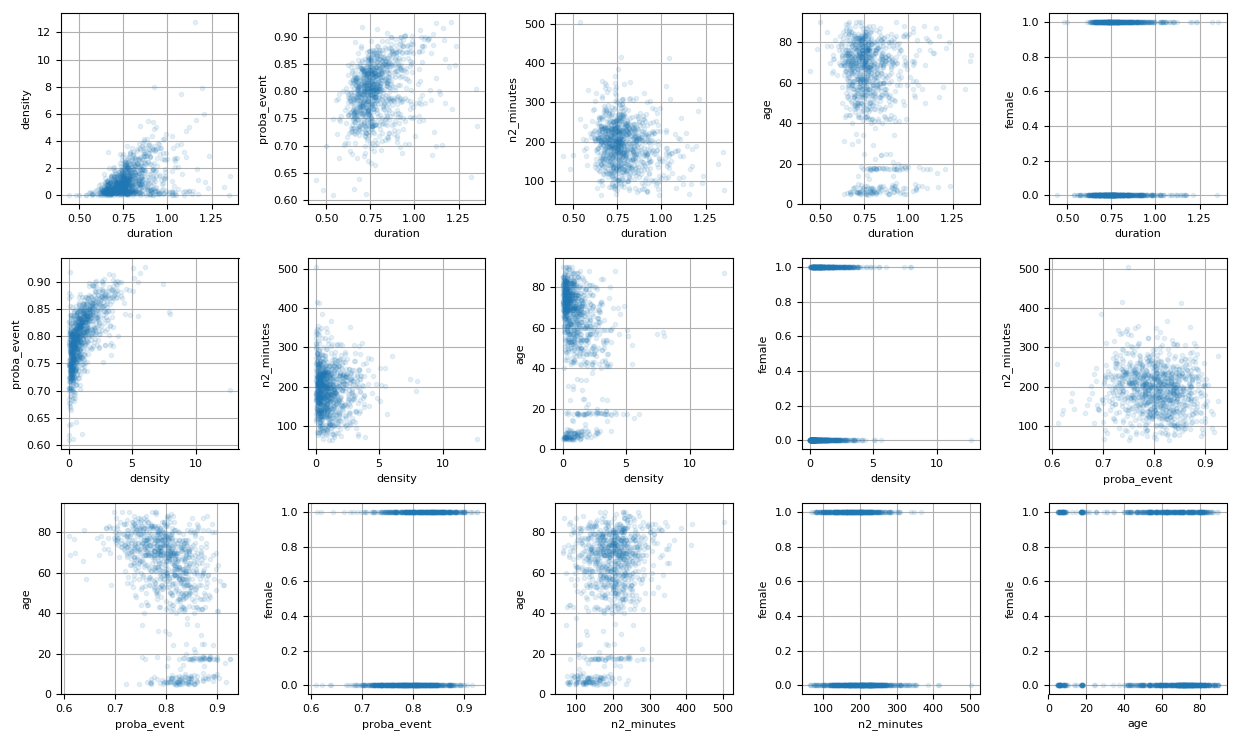

In [137]:
# correlations

param_names = table_bysubject.select_dtypes(include=np.number).columns.tolist()
n_params = len(param_names)
n_plots = n_params * (n_params - 1) / 2
n_cols = 5
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows* 2.5), dpi=100)
axes = axes.flatten()
global_count = -1
for i in range(n_params):
    for j in range(i + 1, n_params):
        global_count += 1
        ax = axes[global_count]
        
        x_data = table_bysubject[param_names[i]].values
        y_data = table_bysubject[param_names[j]].values
        
        ax.plot(x_data, y_data, linestyle="none", marker='o', markersize=3, alpha=0.1)
        ax.set_xlabel(param_names[i], fontsize=8)
        ax.set_ylabel(param_names[j], fontsize=8)
        
        ax.tick_params(labelsize=8)
        ax.grid()
plt.tight_layout()
plt.show()

In [16]:
table_bysubject[table_bysubject.duration > 1.2]

,subject_id,duration,density,proba_event,n2_minutes,origin,age,female
14,ccshs-trec-1800322,1.208157,5.684746,0.926404,295.0,ccshs-trec-180,17.42,1
166,chat-baseline-nonrandomized-300709,1.237407,2.918919,0.881910,111.0,chat-baseline-nonrandomized-30,8.80,1
200,mros-visit1-aa0121,1.314660,1.741228,0.716969,228.0,mros-visit1-aa,74.00,0
337,mros-visit1-aa3470,1.346667,0.034483,0.803385,174.0,mros-visit1-aa,71.00,0
532,shhs1-201228,1.229787,0.421525,0.847463,111.5,shhs1-20,80.00,1
538,shhs1-201274,1.357455,0.758621,0.736506,145.0,shhs1-20,74.00,1
561,shhs1-201523,1.211586,0.785908,0.768129,369.0,shhs1-20,77.00,0
574,shhs1-201581,1.480000,0.011029,0.965332,272.0,shhs1-20,47.00,1
909,shhs1-205404,1.321395,0.500000,0.643717,172.0,shhs1-20,57.00,1


# Check stats of all pages

In [138]:
spectra = []
all_std = []
large_subjects = []
origin_subject_id = []
origin_page_id = []
for subject_id in predictions.all_ids:
    signal = nsrr.get_subject_signal(subject_id, normalize_clip=False)
    n2_pages = predictions.data[subject_id]['n2_pages']
    n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
    
    if n2_minutes < 60:
        continue
    
    x_pages = signal.reshape(-1, nsrr.original_page_duration * nsrr.fs)[n2_pages]
    for i_n2, x in enumerate(x_pages):
        freq, power = utils.power_spectrum_by_sliding_window(x, nsrr.fs, window_duration=2)
        spectra.append(power)
        this_std = x.std()
        all_std.append(this_std)
        origin_subject_id.append(subject_id)
        origin_page_id.append(n2_pages[i_n2])
        if this_std > 50:
            large_subjects.append(subject_id)
spectra = np.stack(spectra, axis=0)
all_std = np.array(all_std)
large_subjects = np.unique(large_subjects)
origin_subject_id = np.array(origin_subject_id)
origin_page_id = np.array(origin_page_id)
print("Done")
print(spectra.shape, all_std.shape, large_subjects.shape)

Done
(396666, 201) (396666,) (131,)


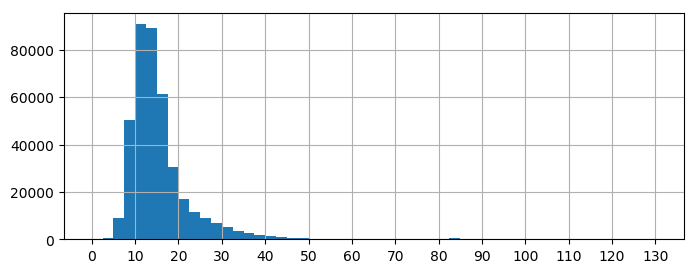

STD -- Min 0.1933, Mean 15.8058, Median 13.7657, Max 121.4612
STD -- Percentile 0.5: 6.1452
STD -- Percentile 99.5: 73.3358
3642 396666 0.9181528036181573


In [139]:
# std hist
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=100)
ax.hist(all_std, bins=np.arange(0, 130 + 0.001, 2.5))
ax.set_xticks(np.arange(0, 130 + 0.001, 10))
ax.grid()
plt.show()

print("STD -- Min %1.4f, Mean %1.4f, Median %1.4f, Max %1.4f" % (all_std.min(), all_std.mean(), np.median(all_std), all_std.max()))

# Central 95% of pages
# STD between 7.5 and 36.
# Central 99% of pages
# STD between 6.15 and 73.34

prctl = 0.5
print("STD -- Percentile %s: %1.4f" % (prctl, np.percentile(all_std, prctl)))

prctl = 99.5
print("STD -- Percentile %s: %1.4f" % (prctl, np.percentile(all_std, prctl)))
print(np.sum(all_std > 50), all_std.size, 100 * np.sum(all_std > 50)/all_std.size)

-0.820723248935969 1.6037596001041017


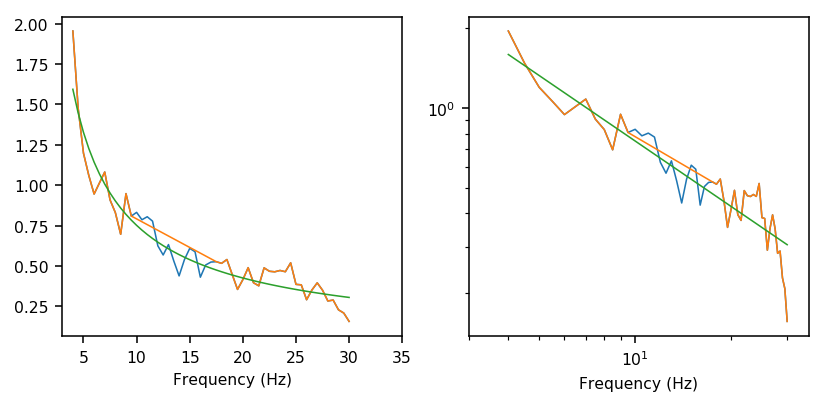

In [108]:
valid_locs = np.where((freq >= 0.3) & (freq <= 30))[0]
freq_short = freq[valid_locs]
spectra_short = spectra[:, valid_locs]

# Compute power law
locs_to_use = np.where(freq_short >= 4)[0]
x_data = freq_short[locs_to_use]
y_data = spectra_short[350, locs_to_use]

locs_no_sigma = np.where((x_data < 10) | (x_data > 17))[0]
x_data_no_sigma = x_data[locs_no_sigma]
y_data_no_sigma = y_data[locs_no_sigma]

log_x = np.log(x_data_no_sigma)
log_y = np.log(y_data_no_sigma)
pl_exponent, pl_intercept, _, _, _ = scipy.stats.linregress(log_x,log_y)
def fitted_power_law(x):
    return (x ** pl_exponent) * np.exp(pl_intercept)
print(pl_exponent, pl_intercept)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=140)

ax = axes[0]
ax.plot(x_data, y_data, linewidth=0.8)
ax.plot(x_data_no_sigma, y_data_no_sigma, linewidth=0.8)
ax.plot(x_data, fitted_power_law(x_data), linewidth=0.8)
ax.set_xlim([3, 35])
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)

ax = axes[1]
ax.plot(x_data, y_data, linewidth=0.8)
ax.plot(x_data_no_sigma, y_data_no_sigma, linewidth=0.8)
ax.plot(x_data, fitted_power_law(x_data), linewidth=0.8)
ax.set_xlim([3, 35])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)
plt.tight_layout()
plt.show()

In [109]:
exponent_list = []
for curve in spectra_short:
    #Compute power law
    locs_to_use = np.where(freq_short >= 4)[0]
    x_data = freq_short[locs_to_use]
    y_data = curve[locs_to_use]

    locs_no_sigma = np.where((x_data < 10) | (x_data > 17))[0]
    x_data_no_sigma = x_data[locs_no_sigma]
    y_data_no_sigma = y_data[locs_no_sigma]
    # Therefore we are considering frequencies 4-10 and 17-30 Hz for the power law.

    log_x = np.log(x_data_no_sigma)
    log_y = np.log(y_data_no_sigma)
    pl_exponent, pl_intercept, _, _, _ = scipy.stats.linregress(log_x,log_y)
    exponent_list.append(pl_exponent)
exponent_list = np.array(exponent_list)

In [117]:
exponent_list.shape

(396666,)

377105 95.06864717419693
-1.8865295794219255 -0.7870561981462284



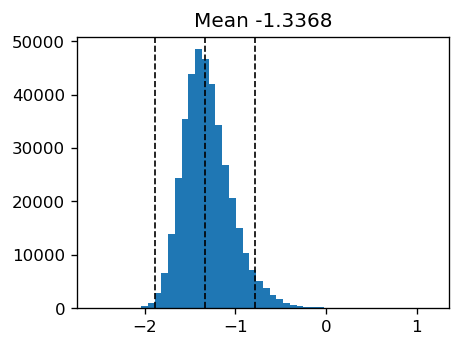

Percentile 0 is -2.5639
Percentile 0.5 is -1.8779
Percentile 5 is -1.6913
Percentile 95 is -0.8097
Percentile 99.5 is -0.3364
Percentile 100 is 1.1670


In [129]:
mean_val = np.median(exponent_list)
disp_val = scipy.stats.median_absolute_deviation(exponent_list)  # dispersion around median
disp_width = 2.2

lower_bound = mean_val - disp_width * disp_val
upper_bound = mean_val + disp_width * disp_val

n_inliers = np.sum((exponent_list >= lower_bound) * (exponent_list <= upper_bound))
print(n_inliers, 100 * n_inliers / exponent_list.size)
print(lower_bound, upper_bound)
print("")

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=120)
ax.hist(exponent_list, bins=50)
ax.axvline(mean_val, color="k", linestyle="--", linewidth=1)
ax.axvline(upper_bound, color="k", linestyle="--", linewidth=1)
ax.axvline(lower_bound, color="k", linestyle="--", linewidth=1)
ax.set_title("Mean %1.4f" % mean_val)
plt.show()

for prct in [0, 0.5, 5, 95, 99.5, 100]:
    value = np.percentile(exponent_list, prct)
    print("Percentile %s is %1.4f" % (prct, value))

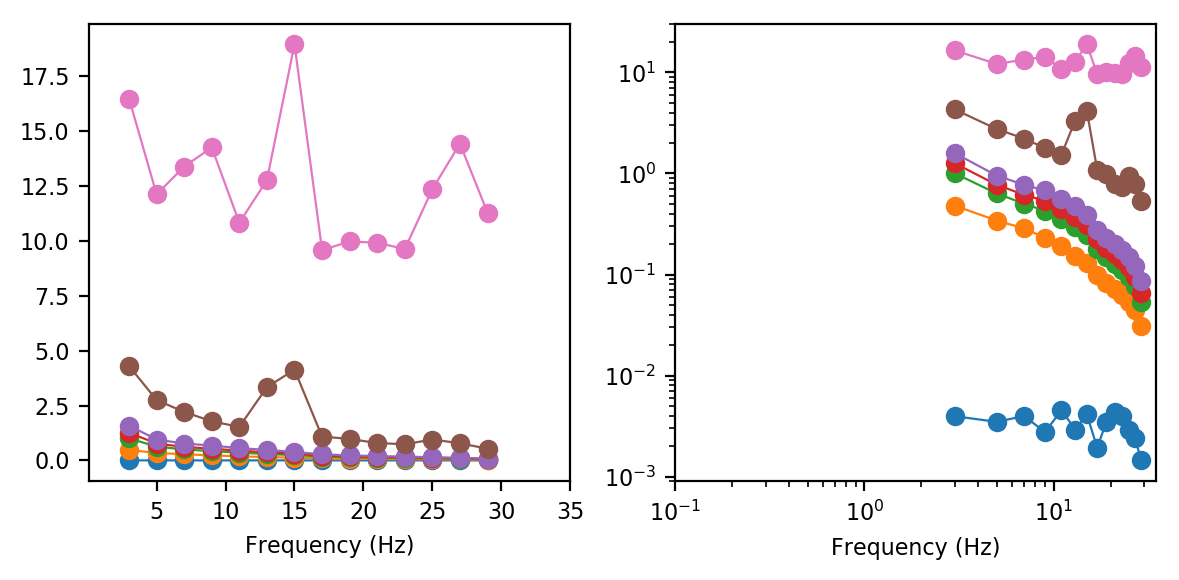

In [81]:
valid_locs = np.where((freq >= 0.3) & (freq <= 30))[0]
freq_short = freq[valid_locs]
spectra_short = spectra[:, valid_locs]

# Compute avg power of 2Hz freq bands
all_p_avg = []
all_f_avg = []
start_freq = 0
width = 2
n_bands = int(np.ceil((freq_short.max() - start_freq) / width))
for i_band in range(n_bands):
    end_freq = start_freq + width
    locs = np.where((f >= start_freq) & (f < end_freq))[0]
    center_freq = (start_freq + end_freq)/2
    start_freq = end_freq
    if center_freq < 2:
        continue
    this_power = spectra_short[:, locs].mean(axis=1)
    all_p_avg.append(this_power)
    all_f_avg.append(center_freq)
    
all_f_avg = np.array(all_f_avg)
all_p_avg = np.stack(all_p_avg, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

ax = axes[0]
prctl_results = np.percentile(all_p_avg, (0, 0.5, 25, 50, 75, 99.5, 100), axis=0)
for curve in prctl_results:
    ax.plot(all_f_avg, curve, linewidth=0.8, marker='o')
ax.set_xlim([0.1, 35])
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)

ax = axes[1]
for curve in prctl_results:
    ax.plot(all_f_avg, curve, linewidth=0.8, marker='o')
ax.set_xlim([0.1, 35])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

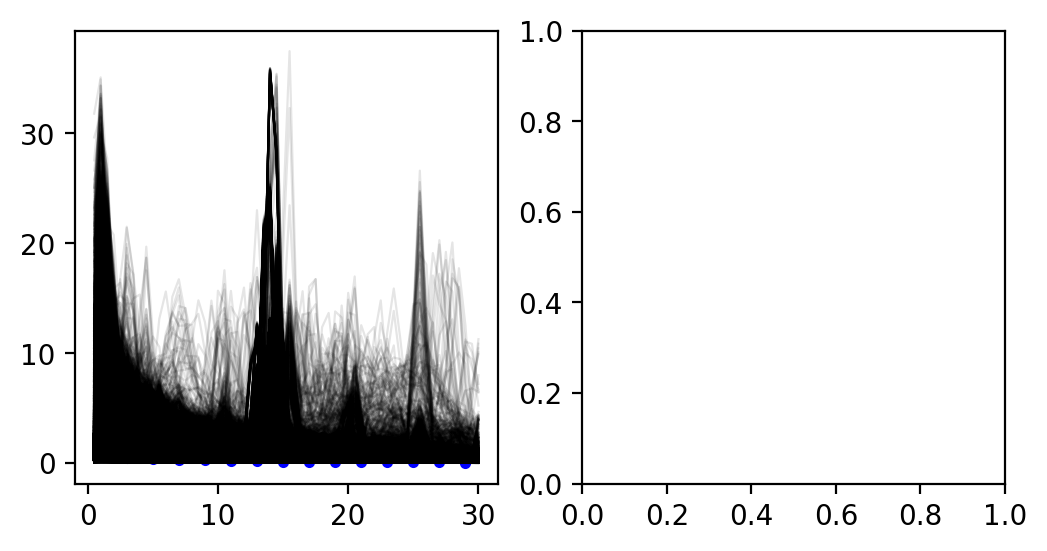

In [84]:
valid_locs = np.where((freq >= 0.3) & (freq <= 30))[0]
freq_short = freq[valid_locs]
spectra_short = spectra[:, valid_locs]

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

prctl_results = np.percentile(all_p_avg, (0.5, 99.5), axis=0)

ax = axes[0]
for curve in prctl_results:
    ax.plot(all_f_avg, curve, linewidth=0.8, marker='o', markersize=3, color="b")
for curve in spectra_short[outliers_locs]:
    ax.plot(freq_short, curve, linewidth=0.8, color="k", alpha=0.1)
ax.set_xlim([0.1, 35])
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)

ax = axes[1]
for curve in prctl_results:
    ax.plot(all_f_avg, curve, linewidth=0.8, marker='o', markersize=3, color="b")
for curve in spectra_short[outliers_locs]:
    ax.plot(freq_short, curve, linewidth=0.8, color="k", alpha=0.1)
ax.set_xlim([0.1, 35])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)
plt.tight_layout()
plt.show()

[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29.]


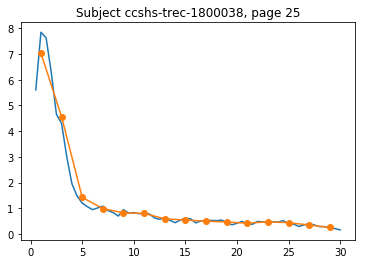

Subject ccshs-trec-1800038, page 25


In [104]:
loc = 350

p = spectra_short[loc]
f = freq_short
# Compute avg power of 2Hz freq bands
p_avg = []
f_avg = []
start_freq = 0
width = 2
n_bands = int(np.ceil((f.max() - start_freq) / width))
for i_band in range(n_bands):
    end_freq = start_freq + width
    locs = np.where((f >= start_freq) & (f < end_freq))[0]
    f_avg.append((start_freq + end_freq)/2)
    p_avg.append(p[locs].mean())
    start_freq = end_freq
f_avg = np.array(f_avg)
p_avg = np.array(p_avg)

plt.plot(f, p)
plt.plot(f_avg, p_avg, marker='o')
print(f_avg)
plt.title("Subject %s, page %d" % (origin_subject_id[loc], origin_page_id[loc]))
plt.show()
print("Subject %s, page %d" % (origin_subject_id[loc], origin_page_id[loc]))

In [83]:
lower_bound, upper_bound = np.percentile(all_p_avg, (0.5, 99.5), axis=0)
print("Original: ", all_p_avg.shape)
spectra_filt = []
inliers_locs = []
outliers_locs = []
for i_page, spec_page in enumerate(all_p_avg):
    if np.all(spec_page >= lower_bound) and np.all(spec_page <= upper_bound):
        spectra_filt.append(spec_page)
        inliers_locs.append(i_page)
    else:
        outliers_locs.append(i_page)
spectra_filt = np.stack(spectra_filt, axis=0)
print("Filtered:", spectra_filt.shape)
print("Percentage kept: %1.4f" % (100 * spectra_filt.shape[0] / all_p_avg.shape[0]))

Original:  (396666, 14)
Filtered: (377972, 14)
Percentage kept: 95.2872


# Check single subject

subject shhs1-202456
Marks (0, 2)
N2 minutes 83.5


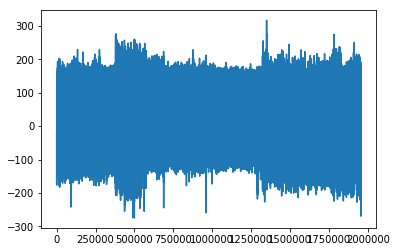

Center samples where STD is greater than 50.0000
[   9000   21000   27000   33000   39000   45000   51000   57000   63000
   69000   75000   81000   87000   99000  105000  117000  129000  141000
  147000  153000  159000  165000  177000  183000  189000  195000  201000
  213000  231000  237000  249000  279000  285000  297000  315000  321000
  327000  333000  345000  363000  369000  585000  591000  603000  621000
  663000  669000  693000  699000  705000  711000  717000  723000  729000
  735000  741000  747000  753000  759000  765000  783000  789000  807000
  825000  843000  849000  867000  885000  891000  897000  903000  909000
  915000  927000  933000  939000  945000  963000  969000  975000  981000
  987000  993000  999000 1005000 1011000 1017000 1023000 1029000 1035000
 1041000 1047000 1053000 1059000 1065000 1071000 1077000 1083000 1089000
 1095000 1101000 1107000 1113000 1119000 1125000 1131000 1137000 1143000
 1149000 1155000 1161000 1173000 1185000 1191000 1203000 1209000 1227000
 1

In [140]:
subject_id = 'shhs1-202456'   # 'shhs1-201711'  # 'sof-visit-8-02332'

print("subject %s" % subject_id)
subject_data = nsrr.read_subject_data(subject_id)
signal = subject_data['signal']
n2_pages = subject_data['n2_pages']
n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
marks = predictions.get_subject_stamps(subject_id, pages_subset='n2')
proba = predictions.get_subject_probabilities(subject_id)
proba_up = np.repeat(proba, 8)
durations = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs

print("Marks", marks.shape)
print("N2 minutes", n2_minutes)

plt.plot(signal)
plt.show()

std_to_find = 50

x_pages_std = signal.reshape(-1, nsrr.original_page_duration * nsrr.fs)[n2_pages].std(axis=1)
n2_pages_locs = np.where(x_pages_std > std_to_find)[0]
std_selected = x_pages_std[n2_pages_locs]
pages_locs = n2_pages[n2_pages_locs]
start_sample = pages_locs * nsrr.original_page_duration * nsrr.fs
center_sample = start_sample + nsrr.original_page_duration * nsrr.fs // 2
print("Center samples where STD is greater than %1.4f" % std_to_find)
print(center_sample)
print(std_selected)

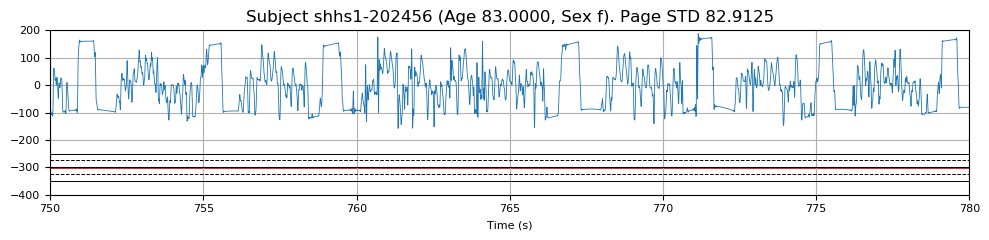

Page STD: 82.9125
-1.2465632828258015 3.37667149120964


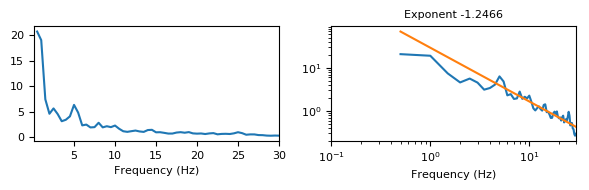

In [144]:
# mark_selected = marks[5]

center_sample = int(25.5 * 30 * 200) # mark_selected.mean()

window_duration = 30
window_size = nsrr.fs * window_duration
start_sample = int(center_sample - window_size // 2)
end_sample = int(start_sample + window_size)
time_axis = np.arange(start_sample, end_sample) / nsrr.fs

fig, ax = plt.subplots(1, 1, figsize=(10, 2.5), dpi=100)

ax.plot(time_axis, signal[start_sample:end_sample], linewidth=.6)

# ax.plot(mark_selected / nsrr.fs, [-100, -100], linewidth=4, color=viz.PALETTE['red'], alpha=0.7)

ax.fill_between(
    time_axis, 
    -300 - 50 * proba_up[start_sample:end_sample], 
    -300 + 50 * proba_up[start_sample:end_sample],
    color=viz.PALETTE['red'], alpha=1.0
)
ax.axhline(-300 - 50, linewidth=0.7, linestyle="-", color="k")
ax.axhline(-300 + 50, linewidth=0.7, linestyle="-", color="k")
ax.axhline(-300 - 25, linewidth=0.7, linestyle="--", color="k")
ax.axhline(-300 + 25, linewidth=0.7, linestyle="--", color="k")
ax.axhline(-300 + 0, linewidth=0.7, linestyle="-", color="k")

ax.set_ylim([-400, 200])
ax.set_xlim([start_sample/nsrr.fs, end_sample/nsrr.fs])

ax.grid()
ax.set_xlabel("Time (s)", fontsize=8)
ax.tick_params(labelsize=8)

page_std = signal[start_sample:end_sample].std()

ax.set_title("Subject %s (Age %1.4f, Sex %s). Page STD %1.4f" % (
    subject_id, subject_data['age'], subject_data['sex'], page_std
))

plt.tight_layout()
plt.show()

print("Page STD: %1.4f" % page_std)

# Compute spectrum of page
freq, power = utils.power_spectrum_by_sliding_window(signal[start_sample:end_sample], nsrr.fs, window_duration=2)
valid_locs = np.where((freq >= 0.3) & (freq <= 30))[0]
freq = freq[valid_locs]
power = power[valid_locs]

locs_to_use = np.where(freq >= 4)[0]
x_data = freq[locs_to_use]
y_data = power[locs_to_use]
locs_no_sigma = np.where((x_data < 10) | (x_data > 17))[0]
x_data_no_sigma = x_data[locs_no_sigma]
y_data_no_sigma = y_data[locs_no_sigma]
log_x = np.log(x_data_no_sigma)
log_y = np.log(y_data_no_sigma)
pl_exponent, pl_intercept, _, _, _ = scipy.stats.linregress(log_x,log_y)
def fitted_power_law(x):
    return (x ** pl_exponent) * np.exp(pl_intercept)
print(pl_exponent, pl_intercept)

fig, axes = plt.subplots(1, 2, figsize=(6, 2), dpi=100)

ax = axes[0]
ax.plot(freq, power)
ax.set_xlim([0.1, 30])
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)

ax = axes[1]
ax.plot(freq, power)
ax.plot(freq, fitted_power_law(freq))
ax.set_xlim([0.1, 30])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)
ax.set_title("Exponent %1.4f" % (pl_exponent), fontsize=8)
plt.tight_layout()
plt.show()